Porto Seguro's Safe Driver Prediction
====

## Introduction
[This competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data) is hosted by the third largest insurance company in Brazil: Porto Seguro with the task of predicting the probability that a driver will initiate an insurance claim in the next year.

In the train data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. **Values of -1 indicate that the feature was missing** from the observation. The target columns signifies whether or not a claim was filed for that policy holder

train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.


In [1]:
# Seems the data is big, for better performance later use. It is best if we read as hdf format
!pip install numpy==1.15.0
!pip install plotly==4.1.0

In [2]:
# Since we store our data in google drive, let's mount drive and access it
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import libraries
# Your code here
# import all standard libraries for data science throughout the course
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [0]:
import os
# Read csv file and take a look at it
filepath = '/content/drive/My Drive'

csv = 'train_porto.csv'
hdf = 'train_porto.h5'

# train = pd.read_csv(os.path.join(filepath, csv))

# Convert to hdf format
# train.to_hdf(os.path.join(filepath, hdf), 'data')

In [0]:
train_hdf = pd.read_hdf(os.path.join(filepath, hdf))

In [6]:
# Taking a look at how many rows and columns the train dataset contains
rows = train_hdf.shape[0]
columns = train_hdf.shape[1]
print("The train dataset contains {} rows and {} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


## 1. Data Quality Checks

### Null or missing values check
Let check whether there are any null values in the train dataset as follows:

In [7]:
# Your code here
train_hdf.isnull().values.any()

False

**Note:** Our null values check returns False but however, this does not really mean that this case has been closed as the data is also described as *"Values of -1 indicate that the feature was missing from the observation"*. Therefore I take it that Porto Seguro has simply conducted a blanket replacement of all null values in the data with the value of -1. Let us now inspect if there where any missing values in the data.

Here we can see that which columns contained -1 in their values so we could easily for example make a blanket replacement of all -1 with nulls first as follows:

In [8]:
# before that let's check if there is any duplicates
train_hdf.drop_duplicates()
train_hdf.shape

(595212, 59)

In [0]:
# Seems ok, let's get started
train_copy = train_hdf.copy()
train_copy = train_copy.replace(-1, np.NaN)

We can use "Missingno" to visualize missing values in the dataset.

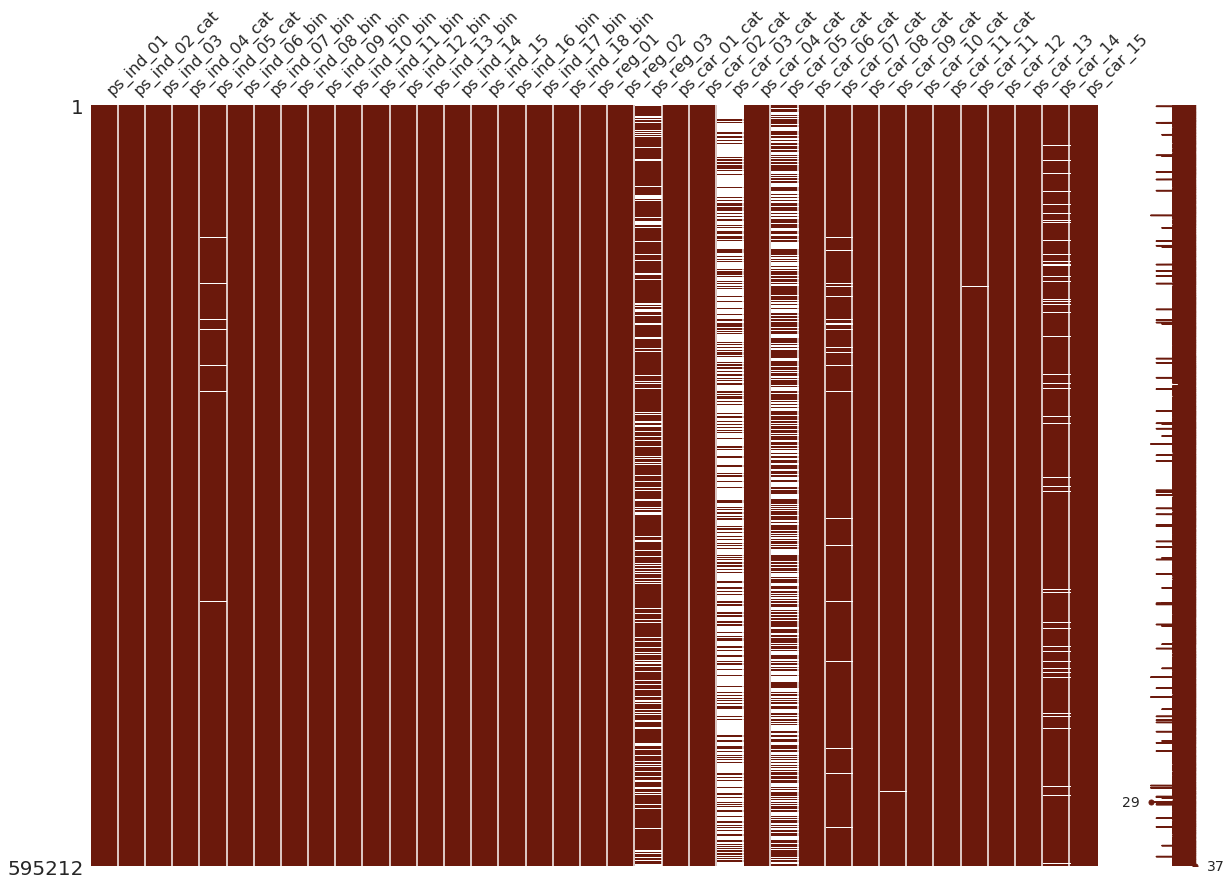

In [10]:
# If you don't have "Missingno" package, use this command to install
# (Linux) conda install -c conda-forge missingno
import missingno as msno

msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [11]:
# List null columns name
# Hint: isnull()
# Your code here
for col in train_copy.columns:
  if not train_copy[col].isnull().any():
    pass
  else:
    print(col + "\t" +str(train_copy[col].isnull().sum()))

ps_ind_02_cat	216
ps_ind_04_cat	83
ps_ind_05_cat	5809
ps_reg_03	107772
ps_car_01_cat	107
ps_car_02_cat	5
ps_car_03_cat	411231
ps_car_05_cat	266551
ps_car_07_cat	11489
ps_car_09_cat	569
ps_car_11	5
ps_car_12	1
ps_car_14	42620


#### Target variable inspection

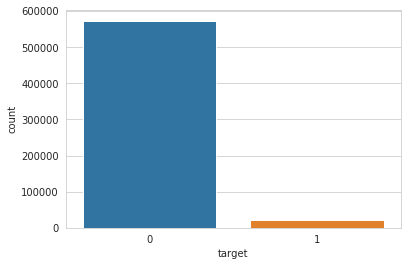

In [12]:
# Using countplot to represent target
# Your code here
ax = sns.countplot(x="target", data=train_copy)

## 2. Feature inspection and filtering

### Correlation plots
As a starter, let us generate some linear correlation plots just to have a quick look at how a feature is linearly correlated to the next and perhaps start gaining some insights from here. At this juncture, I will use the seaborn statistical visualisation package to plot a heatmap of the correlation values. Conveniently, Pandas dataframes come with the corr() method inbuilt, which calculates the Pearson correlation. Also as convenient is Seaborn's way of invoking a correlation plot. Just literally the word "heatmap"

#### Correlation of float features

In [0]:
train_float = train_hdf.select_dtypes(include=['float64'])
train_int = train_hdf.select_dtypes(include=['int64'])

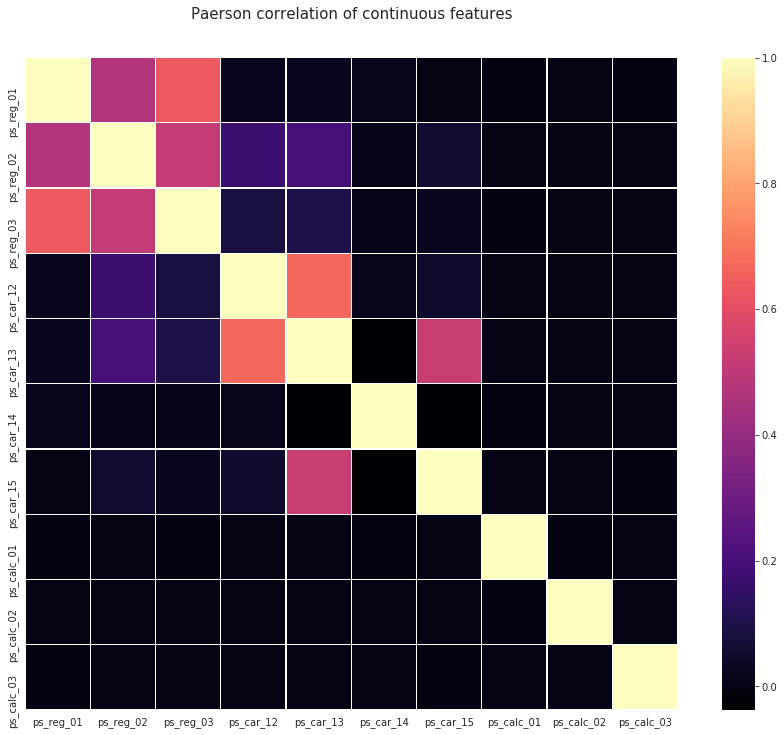

In [14]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title("Paerson correlation of continuous features", y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap=colormap)
plt.show()

From the correlation plot, we can see that the majority of the features display zero or no correlation to one another. This is quite an interesting observation that will warrant our further investigation later down. For now, the paired features that display a positive linear correlation are listed as follows:

(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

### Correlation of integer features

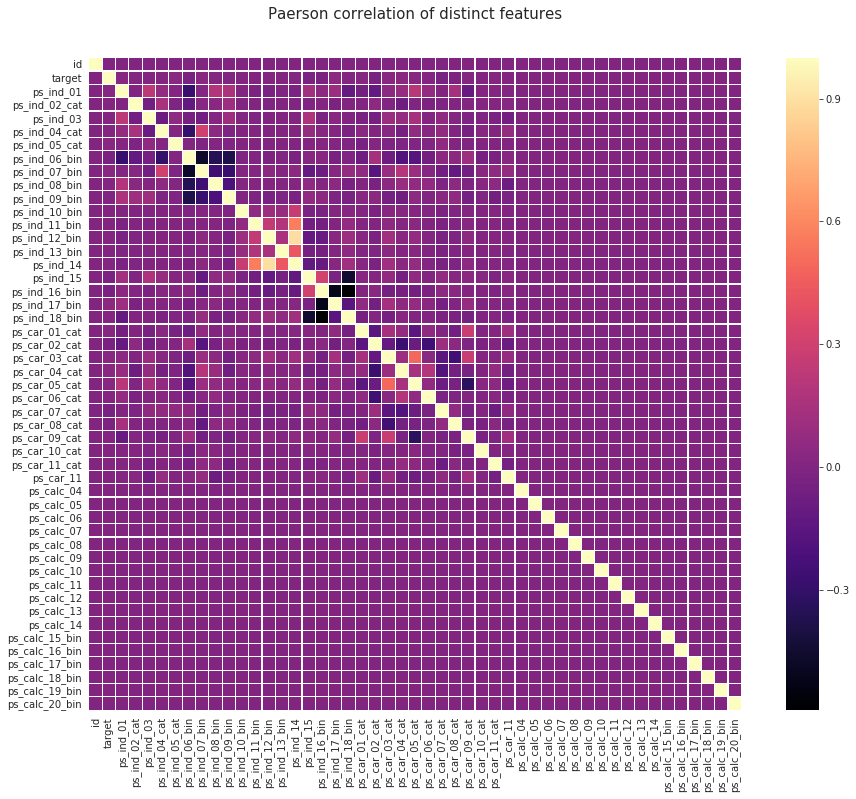

In [15]:
# Your code here
# Hint: correlation of train_int
plt.figure(figsize=(16, 12))
plt.title("Paerson correlation of distinct features", y=1.05, size=15)
sns.heatmap(train_int.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap=colormap)
plt.show()

#### Which features have negatively correlation?
Negatively correlated features : **Your answer here**

### Binary features inspection
Another aspect of the data that we may want to inspect would be the coulmns that only contain binary valeus, i.e where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical plotly bar plot of these binary values as follows:

In [0]:
bin_col = list(filter(lambda x: '_bin' in x, train_hdf.columns))
bin_value_counts = train_hdf[bin_col].apply(pd.value_counts)

In [17]:
bin_value_counts

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,360852,442223,497644,484917,594990,594205,589594,594648,201882,523143,503879,522342,221514,265356,424278,387469,503955
1,234360,152989,97568,110295,222,1007,5618,564,393330,72069,91333,72870,373698,329856,170934,207743,91257


In [18]:
# hint pandas plot.bar with stacked=True
# Your code here
labs = bin_value_counts.columns.to_numpy()
values = bin_value_counts.to_numpy()
# ax = bin_value_counts.plot.bar(stacked = True)
import plotly.graph_objects as go

fig = go.Figure(go.Bar(x = labs, y = values[0], name='0'))
fig.add_trace(go.Bar(x = labs, y = values[1], name='1'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'array', 'categoryarray':['d','a','c','b']})
fig.show()

# Well using plotly is much better, since i forgot how to do it with traditional pandas
# Second, you can hover which is well a little bit nicer, so yeah i think i'll stick with plotly
# Third, documents much better

Those columns ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by zeros. They do not contain much information.

## 3. Preprocess Data

In [0]:
# Import train_test_split 
# Your code here
from sklearn.model_selection import train_test_split

In [0]:
# Define X (features), y (target)
X = train_hdf.drop(columns = ['id', 'target'] )
y = train_hdf['target']

In [0]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### Randomly Under-Sampling the Training Dataset¶
**Note:** Validate ratio between 2 class after Under-Sampling

In [74]:
# Your code here
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

print(X_rus.shape[0]/X.shape[0])


0.07289503571836589


#### Randomly Over-Sampling the Training Dataset
**Note:** Validate ratio between 2 class after Over-Sampling

In [75]:
# Your code here
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_train, y_train)
print(X_sm.shape[0]/X.shape[0])

1.348988259645303


## 4. Modeling

In [0]:
# Spot check with LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, BernoulliNB, GaussianNB
# Import libraries and and create model
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB


lr = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
bnb = BernoulliNB()
gnb = GaussianNB()
svm = LinearSVC()


models = [lr, dtc, rfc, gnb, bnb]
models_name = ["Logistic Regression", "Decision Tree", "Random Forest", "Bernoulli NB", "Gaussian NB"]

## 5. Evaluation Metrics

In [0]:
# Import confusion_matrix, classification_report
# Your code here
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score
# We create an utils function, that take a trained model as argument and print out confusion matrix
# classification report base on X and y
def evaluate_model(estimator, X, y):
    # Your code here
    prediction = estimator.predict(X)
    np.set_printoptions(precision=2)
    model_name = type(estimator).__name__
    return {'name': model_name, 
            'recall': recall_score(y, prediction),
            'precision': precision_score(y, prediction),
           }

### Evaluate with Origin dataset

In [26]:
scores = []
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Origin dataset
    model.fit(X_train, y_train)
    scores.append(evaluate_model(model, X_test, y_test))
    # Evaluate model with X_test, y_test
    print("=======================================")

Model: Logistic Regression
Model: Decision Tree
Model: Random Forest
Model: Bernoulli NB
Model: Gaussian NB


### Evaluate with *Undersampled* dataset

In [27]:
scores_under = []
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Undersampled dataset
    model.fit(X_rus, y_rus)
    scores_under.append(evaluate_model(model, X_test, y_test))
    # Your code here
    # Evaluate model with X_test, y_test
    print("=======================================")

Model: Logistic Regression
Model: Decision Tree
Model: Random Forest
Model: Bernoulli NB
Model: Gaussian NB


### Evaluate with *Oversampled* dataset

In [28]:
scores_over = []
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Oversampled dataset
    model.fit(X_sm, y_sm)
    scores_over.append(evaluate_model(model, X_test, y_test))
    # Evaluate model with X_test, y_test
    print("=======================================")

Model: Logistic Regression
Model: Decision Tree
Model: Random Forest
Model: Bernoulli NB
Model: Gaussian NB


### Conclusion

Which model has lowest/highest accuracy?
Which model has lowest/highest recall?
Which model has lowest/highest f1?

## 6. GridsearchCV

In [0]:
# Using gridsearchcv, random forest model and this param grid to find the best combination of parameters 
# Hint: example
# https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed
from joblib import parallel_backend
def max_feature():
  param_grid = {
      'bootstrap': [True],
      'max_depth': [80, 90, 100, 110],
      'max_features': [2, 3],
      'min_samples_leaf': [3, 4, 5],
      'min_samples_split': [8, 10, 12],
      'n_estimators': [100, 200, 300, 1000]
  }
  rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True)

  from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
  # Define metrics to evaluate model
  scorers = {
      'recall_score': make_scorer(recall_score),
      'precision_score': make_scorer(precision_score),
      'accuracy_score': make_scorer(accuracy_score)
  }
  
  gridcv =GridSearchCV(estimator=rfc, param_grid=param_grid, scoring=scorers, refit='recall_score', return_train_score=True, verbose=5)

  gridcv.fit(X_train, y_train)
  
  return gridcv

#### which is the best combination of parameter

In [56]:
# Your code here
from joblib import Parallel, delayed
from joblib import parallel_backend
if __name__ == '__main__':
  gridcv = max_feature()
  print (gridcv.best_estimator_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy_score=(train=0.964, test=0.964), precision_score=(train=1.000, test=0.000), recall_score=(train=0.000, test=0.000), total=  40.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy_score=(train=0.964, test=0.964), precision_score=(train=0.000, test=0.000), recall_score=(train=0.000, test=0.000), total=  37.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy_score=(train=0.964, test=0.964), precision_score=(train=0.000, test=0.000), recall_score=(train=0.000, test=0.000), total=  38.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy_score=(train=0.964, test=0.964), precision_score=(train=0.000, test=0.000), recall_score=(train=0.000, test=0.000), total= 1.2min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.7min remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy_score=(train=0.964, test=0.964), precision_score=(train=0.000, test=0.000), recall_score=(train=0.000, test=0.000), total= 1.3min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy_score=(train=0.964, test=0.964), precision_score=(train=0.000, test=0.000), recall_score=(train=0.000, test=0.000), total= 1.2min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy_score=(train=0.964, test=0.964), precision_score=(train=0.000, test=0.000), recall_score=(train=0.000, test=0.000), total= 1.9min
[CV] bootstrap=True, max_depth

KeyboardInterrupt: ignored

In [0]:
# Well yeah, taking like darn fking forever
# It is pretty reasonable since first: the dataset is huge and second is:
# For whatever the reason is, GridSearchCV seems not able to run with num_jobs aside 1
# It does not give any error. Just simply freeze for quite a long time
# And wtf with those heinous number of the score???? Yeah pretty much bs
# So now maybe the time we test with undersampling, since our dataset is huge
def max_feature():
  # Well if run overnight then maybe, however in short time so let's cut down some param values
  param_grid = {
      'bootstrap': [True],
      'max_depth': [80],
      'max_features': [2],
      'min_samples_leaf': [3, 4],
      'min_samples_split': [8, 10],
      'n_estimators': [100, 200, 300, 1000]
  }
  rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True)

  from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
  # Define metrics to evaluate model
  scorers = {
      'recall_score': make_scorer(recall_score),
      'precision_score': make_scorer(precision_score),
      'accuracy_score': make_scorer(accuracy_score)
  }
  
  gridcv =GridSearchCV(estimator=rfc, param_grid=param_grid, scoring=scorers, refit='recall_score', return_train_score=True, verbose=5)

  gridcv.fit(X_rus, y_rus)
  
  return gridcv

In [79]:
gridcv_under = max_feature()
print (gridcv_under.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy_score=(train=0.965, test=0.586), precision_score=(train=0.966, test=0.588), recall_score=(train=0.963, test=0.573), total=   4.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy_score=(train=0.965, test=0.586), precision_score=(train=0.969, test=0.585), recall_score=(train=0.960, test=0.591), total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy_score=(train=0.964, test=0.592), precision_score=(train=0.967, test=0.596), recall_score=(train=0.962, test=0.575), total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy_score=(train=0.971, test=0.592), precision_score=(train=0.973, test=0.596), recall_score=(train=0.969, test=0.575), total=   5.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy_score=(train=0.971, test=0.592), precision_score=(train=0.975, test=0.592), recall_score=(train=0.966, test=0.592), total=   5.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy_score=(train=0.973, test=0.589), precision_score=(train=0.974, test=0.593), recall_score=(train=0.973, test=0.567), total=   5.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy_score=(train=0.973, test=0.592), precision_score=(train=0.973, test=0.595), recall_score=(train=0.973, test=0.579), total=   7.7s
[CV] bootstrap=True, max_depth

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 11.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=80, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)


In [0]:
# Hey seems like i am quite an ass for like delete way too much
# But hey, desperate situation require desperate measure
# Anyhow, seems like need to work on multithread and stuffs
# Thks

# Done! Great Job.